In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
import tensorflow.keras.layers as tfl

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D  # Ensure this is imported
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Constants
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "H:\\Recyclable_Household_waste\\archive_2\\images\\images" 

# Data Augmentation for the training set
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])


In [3]:
# Define preprocessing function
def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (Rescaling(1./255)(x), y))

# Load the training dataset (before applying map)
raw_train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42
)


Found 15000 files belonging to 30 classes.
Using 12000 files for training.


In [4]:
# Store class names before transformations
class_names = raw_train_dataset.class_names
print(f"Class names: {class_names}")

Class names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


In [5]:
# Apply data augmentation to the training dataset
train_dataset = raw_train_dataset.map(lambda x, y: (data_augmentation(x), y))
train_dataset = preprocess_dataset(train_dataset)

# Load the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42
)
validation_dataset = preprocess_dataset(validation_dataset)

Found 15000 files belonging to 30 classes.
Using 3000 files for validation.


In [6]:
# Build the MobileNetV2 model with transfer learning
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

In [7]:
# Add custom layers for your dataset
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # Output layer
])

In [8]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,425,822 (9.25 MB)

 Trainable params: 167,838 (655.62 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Train the model
EPOCHS = 35
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/35
375/375 ━━━━━━━━━━━━━━━━━━━━ 248s 647ms/step - accuracy: 0.0790 - loss: 3.4996 - val_accuracy: 0.3563 - val_loss: 2.5279
Epoch 2/35
375/375 ━━━━━━━━━━━━━━━━━━━━ 225s 600ms/step - accuracy: 0.2780 - loss: 2.6230 - val_accuracy: 0.4857 - val_loss: 1.8813
Epoch 3/35
375/375 ━━━━━━━━━━━━━━━━━━━━ 220s 587ms/step - accuracy: 0.3863 - loss: 2.1965 - val_accuracy: 0.5367 - val_loss: 1.6096
Epoch 4/35
375/375 ━━━━━━━━━━━━━━━━━━━━ 220s 587ms/step - accuracy: 0.4341 - loss: 1.9730 - val_accuracy: 0.5913 - val_loss: 1.4252
Epoch 5/35
375/375 ━━━━━━━━━━━━━━━━━━━━ 220s 587ms/step - accuracy: 0.4761 - loss: 1.8178 - val_accuracy: 0.6120 - val_loss: 1.3190
Epoch 6/35
375/375 ━━━━━━━━━━━━━━━━━━━━ 221s 588ms/step - accuracy: 0.4938 - loss: 1.7531 - val_accuracy: 0.6277 - val_loss: 1.2513
Epoch 7/35
375/375 ━━━━━━━━━━━━━━━━━━━━ 220s 586ms/step - accuracy: 0.5053 - loss: 1.6853 - val_accuracy: 0.6477 - val_loss: 1.1928
Epoch 8/35
375/375 ━━━━━━━━━━━━━━━━━━━━ 219s 585ms/step - accuracy: 0.5253 -

In [11]:
# Fine-tuning step: Unfreeze some layers of the base model
print("\nUnfreezing the top layers of the base model for fine-tuning...")
base_model.trainable = True  # Unfreeze all layer


Unfreezing the top layers of the base model for fine-tuning...


In [12]:
# Optionally freeze the lower layers
for layer in base_model.layers[:-30]:  # Keep lower 30 layers frozen
    layer.trainable = False

In [13]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# Fine-tune the model
FINE_TUNE_EPOCHS = 15
history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=FINE_TUNE_EPOCHS
)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 265s 683ms/step - accuracy: 0.5092 - loss: 1.6820 - val_accuracy: 0.7160 - val_loss: 0.8890
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 249s 664ms/step - accuracy: 0.5815 - loss: 1.4019 - val_accuracy: 0.7150 - val_loss: 0.8978
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 248s 660ms/step - accuracy: 0.6013 - loss: 1.3079 - val_accuracy: 0.7180 - val_loss: 0.8866
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 249s 663ms/step - accuracy: 0.6288 - loss: 1.2401 - val_accuracy: 0.7203 - val_loss: 0.8762
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 249s 664ms/step - accuracy: 0.6347 - loss: 1.2067 - val_accuracy: 0.7187 - val_loss: 0.8648
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 248s 661ms/step - accuracy: 0.6436 - loss: 1.1540 - val_accuracy: 0.7240 - val_loss: 0.8555
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 249s 663ms/step - accuracy: 0.6505 - loss: 1.1308 - val_accuracy: 0.7287 - val_loss: 0.8353
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 249s 663ms/step - accuracy: 0.6547 -

In [15]:
# Evaluate the model
val_images = []
val_labels = []
for images, labels in validation_dataset:
    val_images.append(images)
    val_labels.append(labels)

val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

In [16]:
# Predictions
predictions = model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(val_labels.numpy(), axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 382ms/step


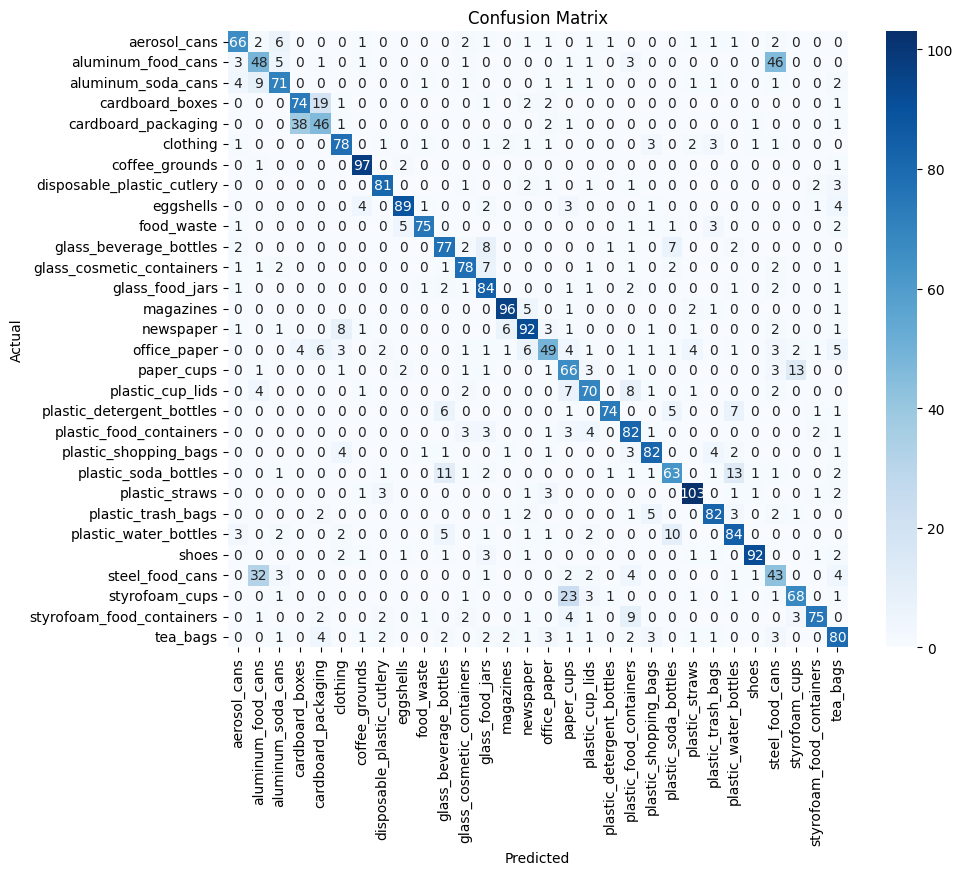

In [17]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
                             precision    recall  f1-score   support

              aerosol_cans       0.80      0.76      0.78        87
        aluminum_food_cans       0.48      0.44      0.46       110
        aluminum_soda_cans       0.76      0.76      0.76        94
           cardboard_boxes       0.64      0.74      0.69       100
       cardboard_packaging       0.57      0.51      0.54        90
                  clothing       0.78      0.81      0.80        96
            coffee_grounds       0.90      0.96      0.93       101
disposable_plastic_cutlery       0.88      0.88      0.88        92
                 eggshells       0.90      0.85      0.87       105
                food_waste       0.93      0.84      0.88        89
    glass_beverage_bottles       0.73      0.77      0.75       100
 glass_cosmetic_containers       0.80      0.80      0.80        97
           glass_food_jars       0.71      0.87      0.78        97
                 magazi

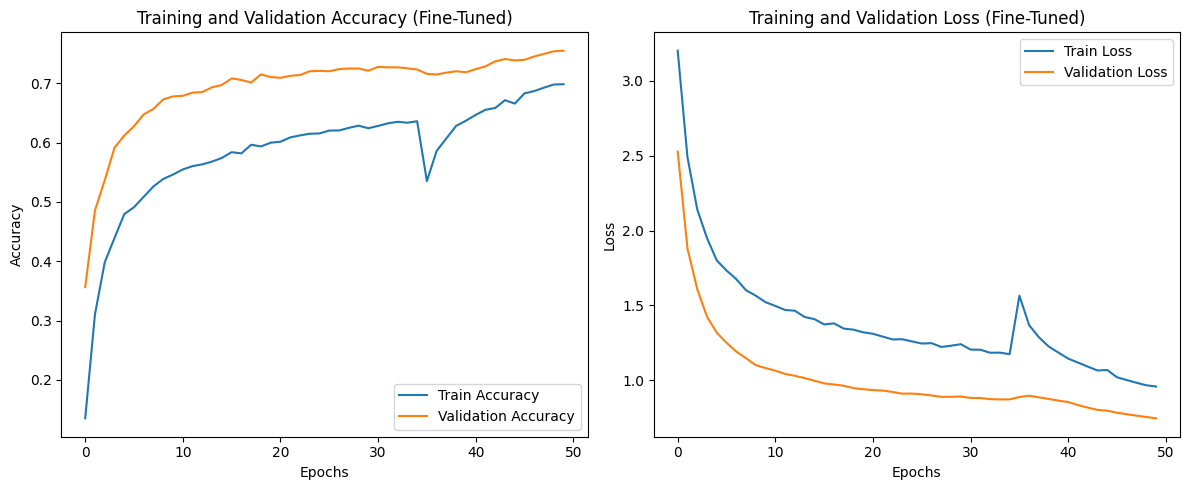

In [19]:
# Training Visualization
def plot_training_history(history, history_fine):
    # Combine history for visualization
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy (Fine-Tuned)')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Fine-Tuned)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history, history_fine)

In [20]:
# Validation Dataset
val_images = []
val_labels = []

# Extract images and labels from the validation dataset
for images, labels in validation_dataset:
    val_images.append(images)
    val_labels.append(labels)

val_images = tf.concat(val_images, axis=0)  # Combine images
val_labels = tf.concat(val_labels, axis=0)  # Combine labels

print("Number of images in validation set:", val_images.shape)
print("True labels shape:", val_labels.shape)

# Check the first prediction
predictions = model.predict(val_images)
print("Shape of predictions:", predictions.shape)
print("Sample prediction (first image):", predictions[0])



Number of images in validation set: (3000, 224, 224, 3)
True labels shape: (3000, 30)
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 371ms/step
Shape of predictions: (3000, 30)
Sample prediction (first image): [2.1677324e-06 3.5013770e-07 8.6007975e-07 9.6291345e-08 8.2533305e-08
 7.4476275e-06 9.8472604e-08 1.4113434e-07 7.2687816e-09 1.1648965e-07
 6.8664856e-09 7.5164053e-08 7.4171979e-08 6.1600133e-08 1.5795284e-05
 1.8639180e-06 1.8474834e-07 1.9884217e-07 2.0788766e-06 1.3799041e-06
 6.9511839e-07 1.2427852e-06 6.6549464e-09 6.4860660e-07 1.3434031e-06
 9.9996209e-01 1.8411534e-07 4.3554143e-09 4.5562115e-07 1.9887516e-07]


In [21]:
# Predictions
predictions = model.predict(val_images)  # Get probabilities
predicted_classes = np.argmax(predictions, axis=1)  # Convert to class indices
true_classes = np.argmax(val_labels.numpy(), axis=1)  # Convert true labels to class indices

print("Class names:", class_names)

94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step
Class names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


In [22]:
def display_predictions(images, true_labels, predicted_labels, class_names, num_images=6):
    plt.figure(figsize=(12, 8))
    
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert to uint8 for display
        true_class = class_names[true_labels[i]]
        predicted_class = class_names[predicted_labels[i]]
        
        # Add title with true and predicted labels
        color = "green" if true_class == predicted_class else "red"
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


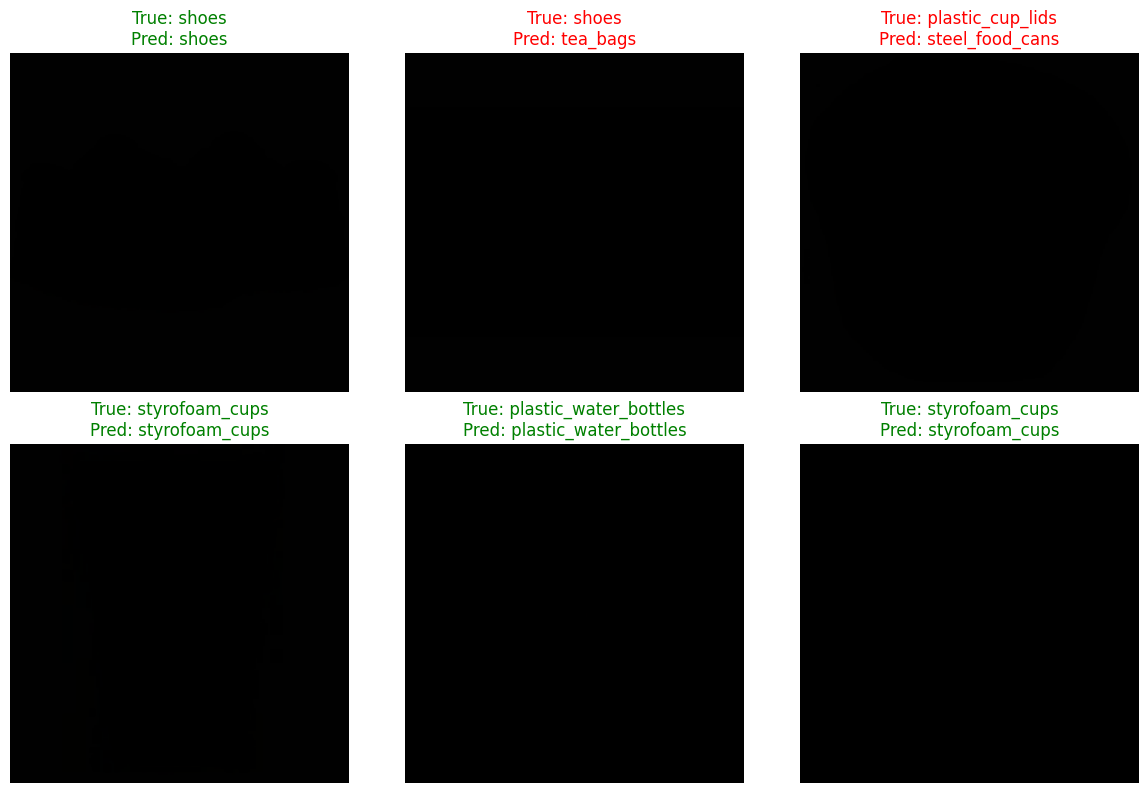

In [23]:
# Ensure the predictions and true labels are integers
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(val_labels.numpy(), axis=1)

# Call the display function
display_predictions(val_images, true_classes, predicted_classes, class_names)



In [24]:
print("Image tensor range:", tf.reduce_min(val_images), "to", tf.reduce_max(val_images))


Image tensor range: tf.Tensor(0.0, shape=(), dtype=float32) to tf.Tensor(1.0, shape=(), dtype=float32)


In [25]:
images_for_display = (val_images * 255).numpy().astype("uint8")


In [26]:
def display_predictions(images, true_labels, predicted_labels, class_names, num_images=6):
    images_for_display = (images * 255).numpy().astype("uint8")  # Rescale images
    plt.figure(figsize=(12, 8))
    
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images_for_display[i])  # Use rescaled images
        true_class = class_names[true_labels[i]]
        predicted_class = class_names[predicted_labels[i]]
        
        color = "green" if true_class == predicted_class else "red"
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


In [27]:
print("Sample Image Tensor:", val_images[0])


Sample Image Tensor: tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(224, 224, 3), dtype=float32)


In [28]:
for image, label in validation_dataset.take(1):  # Take one batch
    print("Image shape:", image.shape)
    print("Image values range:", tf.reduce_min(image), "to", tf.reduce_max(image))


Image shape: (32, 224, 224, 3)
Image values range: tf.Tensor(0.0, shape=(), dtype=float32) to tf.Tensor(1.0, shape=(), dtype=float32)


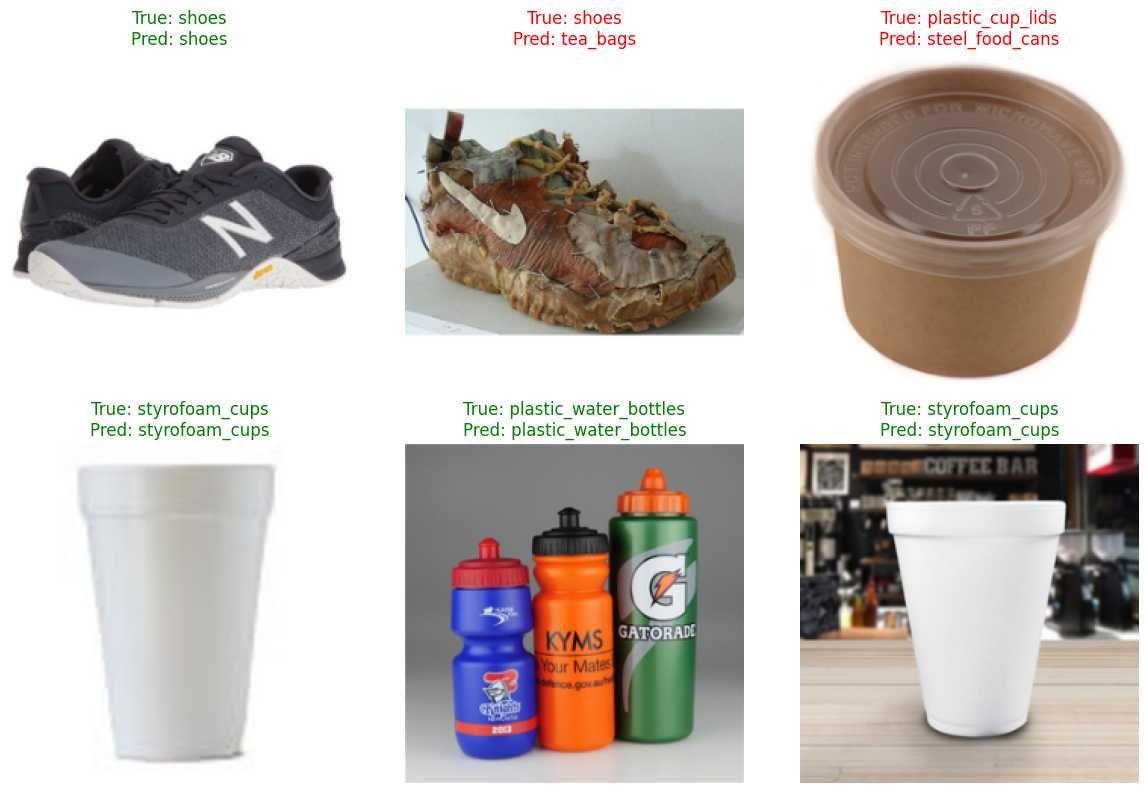

In [29]:
display_predictions(val_images, true_classes, predicted_classes, class_names)
